In [1]:
# Baixa e extrai o dataset
!mkdir data/
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  1852k      0  0:00:06  0:00:06 --:--:-- 3233k
Archive:  data/animais.zip
   creating: data/animais/
   creating: data/animais/val/
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [5]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [6]:
model = models.resnet18()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 1, Train Loss: 0.702, Train Accuracy: 52.00%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.677, Val Accuracy: 57.38%


100%|██████████| 13/13 [00:02<00:00,  6.23it/s]


Epoch 2, Train Loss: 0.704, Train Accuracy: 54.25%
Epoch 2, Val Loss: 0.733, Val Accuracy: 45.90%


100%|██████████| 13/13 [00:02<00:00,  6.00it/s]


Epoch 3, Train Loss: 0.699, Train Accuracy: 52.75%
Epoch 3, Val Loss: 0.694, Val Accuracy: 53.28%


100%|██████████| 13/13 [00:02<00:00,  6.10it/s]


Epoch 4, Train Loss: 0.679, Train Accuracy: 55.75%
Epoch 4, Val Loss: 0.659, Val Accuracy: 54.92%


100%|██████████| 13/13 [00:02<00:00,  6.32it/s]


Epoch 5, Train Loss: 0.691, Train Accuracy: 56.75%
Epoch 5, Val Loss: 0.664, Val Accuracy: 59.84%
Treinamento concluído


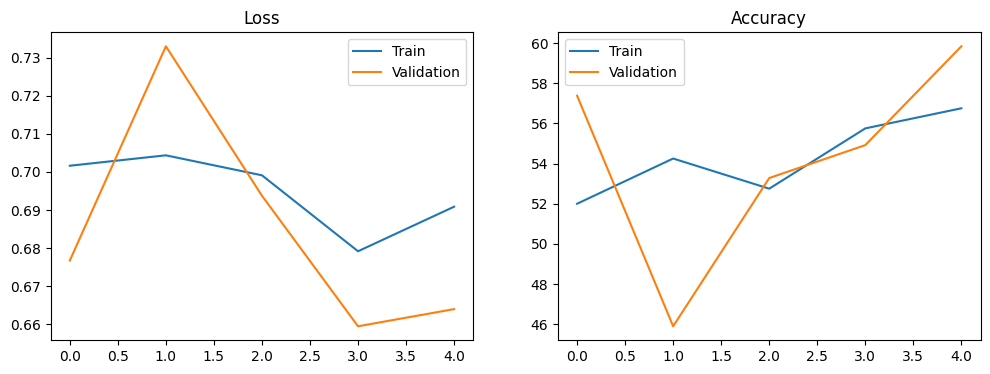

Acurácia da rede na base de teste: 59.84%


In [8]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [9]:
# Utilizando pesos pré-treinados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.1MB/s]


In [10]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [11]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Epoch 1, Train Loss: 0.612, Train Accuracy: 66.00%
Epoch 1, Val Loss: 0.367, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:01<00:00,  7.66it/s]


Epoch 2, Train Loss: 0.424, Train Accuracy: 83.25%
Epoch 2, Val Loss: 0.225, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


Epoch 3, Train Loss: 0.329, Train Accuracy: 88.00%
Epoch 3, Val Loss: 0.190, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Epoch 4, Train Loss: 0.278, Train Accuracy: 88.50%
Epoch 4, Val Loss: 0.157, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Epoch 5, Train Loss: 0.231, Train Accuracy: 92.50%
Epoch 5, Val Loss: 0.160, Val Accuracy: 95.90%
Treinamento concluído


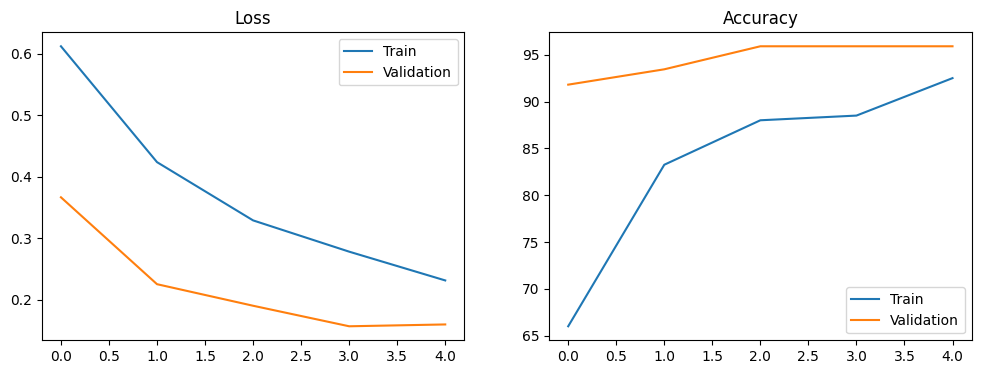

Acurácia da rede na base de teste: 95.90%


In [12]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [13]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

In [14]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

Output hidden; open in https://colab.research.google.com to view.

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

In [15]:
# carregar dados sem data aug
train_set_ex1 = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                 transform=transform_no_aug)
val_set_ex1 = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                               transform=transform_no_aug)

# criar os dataloaders
train_loader_ex1 = DataLoader(train_set_ex1, batch_size=32, shuffle=True)
val_loader_ex1 = DataLoader(val_set_ex1, batch_size=32, shuffle=True)

In [16]:
# carregar modelo
model_ex1 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# congelar camadas
for param in model_ex1.parameters():
  param.requires_grad = False

# Substituir a última camada
model_ex1.fc = nn.Linear(model_ex1.fc.in_features, 2)
model_ex1 = model_ex1.to(device)

100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


Epoch 1, Train Loss: 0.731, Train Accuracy: 50.25%
Epoch 1, Val Loss: 0.454, Val Accuracy: 86.89%


100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


Epoch 2, Train Loss: 0.344, Train Accuracy: 90.50%
Epoch 2, Val Loss: 0.232, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


Epoch 3, Train Loss: 0.236, Train Accuracy: 93.00%
Epoch 3, Val Loss: 0.197, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:02<00:00,  5.00it/s]


Epoch 4, Train Loss: 0.187, Train Accuracy: 95.00%
Epoch 4, Val Loss: 0.159, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Epoch 5, Train Loss: 0.173, Train Accuracy: 95.75%
Epoch 5, Val Loss: 0.159, Val Accuracy: 95.08%
Treinamento concluído


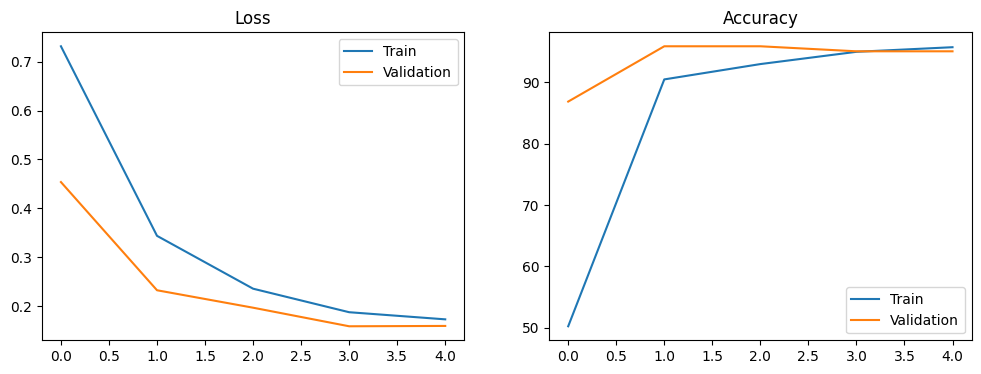

Acurácia da rede na base de teste: 95.08%


In [17]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ex1.parameters(), lr=0.001, momentum=0.9)

history = train_model(model_ex1, train_loader_ex1, val_loader_ex1, criterion,
                      optimizer, device, num_epochs=5)

plot_history(history)
test_model(model_ex1, val_loader_ex1)

Em relação as curvas de treinamento e validação, é possível notar um momento em a acc na base de treino é mais alta que a de val, o que mostra um possível momento de overfitting do modelo.

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [19]:
# carregar modelo
model_ex2 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [20]:
model_ex2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# congelando a camada 4 e 3
for name, layer in model_ex2.named_children():
    if name in ['layer4', 'layer3']:
        for param in layer.parameters():
            param.requires_grad = False

In [22]:
# Substituir a última camada
model_ex2.fc = nn.Linear(model_ex2.fc.in_features, 2)
model_ex2 = model_ex2.to(device)

100%|██████████| 13/13 [00:02<00:00,  6.29it/s]


Epoch 1, Train Loss: 0.669, Train Accuracy: 60.00%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.525, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


Epoch 2, Train Loss: 0.431, Train Accuracy: 80.50%
Epoch 2, Val Loss: 0.225, Val Accuracy: 97.54%


100%|██████████| 13/13 [00:02<00:00,  6.13it/s]


Epoch 3, Train Loss: 0.308, Train Accuracy: 89.00%
Epoch 3, Val Loss: 0.180, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:01<00:00,  6.69it/s]


Epoch 4, Train Loss: 0.262, Train Accuracy: 89.50%
Epoch 4, Val Loss: 0.143, Val Accuracy: 97.54%


100%|██████████| 13/13 [00:01<00:00,  6.68it/s]


Epoch 5, Train Loss: 0.227, Train Accuracy: 90.50%
Epoch 5, Val Loss: 0.143, Val Accuracy: 97.54%
Treinamento concluído


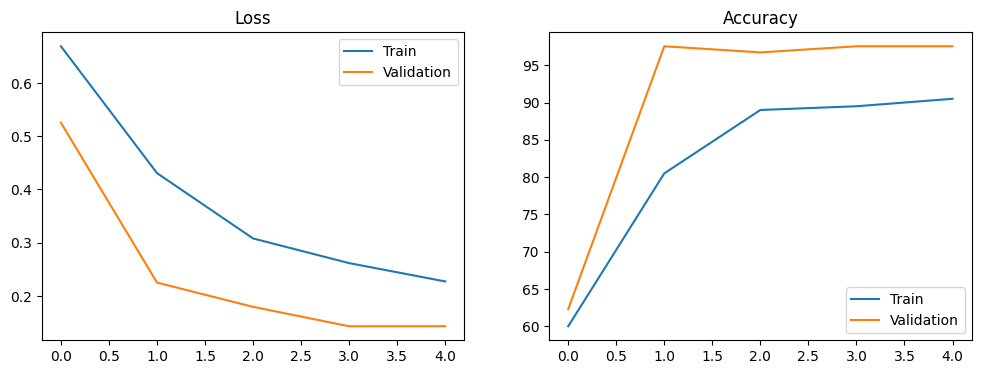

Acurácia da rede na base de teste: 97.54%


In [23]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ex2.parameters(), lr=0.001, momentum=0.9)

history = train_model(model_ex2, train_loader, val_loader, criterion,
                      optimizer, device, num_epochs=5)

plot_history(history)
test_model(model_ex2, val_loader)

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [26]:
# carregar modelo da vgg16
model_ex3 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 143MB/s]


In [27]:
model_ex3

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
in_features_vgg16 = model_ex3.classifier[6].in_features
in_features_vgg16

4096

In [37]:
# alterando ultima camada
model_ex3.classifier[6] = nn.Linear(in_features_vgg16, 2)

In [38]:
model_ex3.classifier[6]

Linear(in_features=4096, out_features=2, bias=True)

100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


Epoch 1, Train Loss: 0.424, Train Accuracy: 78.75%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.138, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


Epoch 2, Train Loss: 0.233, Train Accuracy: 90.25%
Epoch 2, Val Loss: 0.100, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


Epoch 3, Train Loss: 0.235, Train Accuracy: 90.00%
Epoch 3, Val Loss: 0.091, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


Epoch 4, Train Loss: 0.179, Train Accuracy: 92.75%
Epoch 4, Val Loss: 0.064, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 5, Train Loss: 0.121, Train Accuracy: 95.00%
Epoch 5, Val Loss: 0.070, Val Accuracy: 95.90%
Treinamento concluído


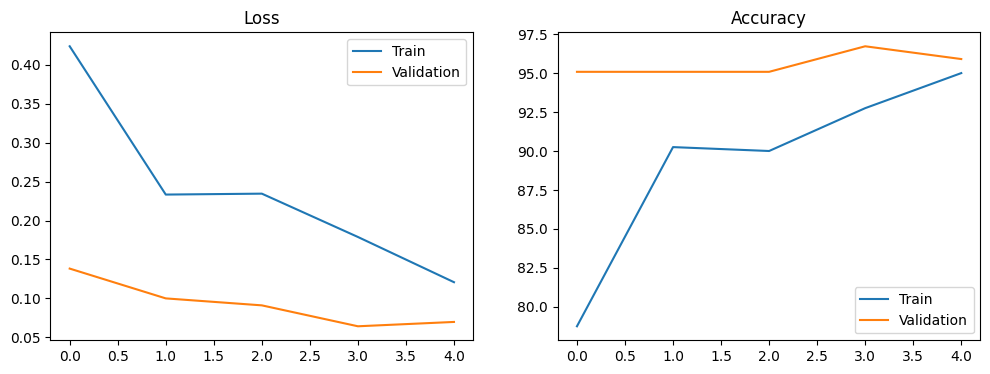

Acurácia da rede na base de teste: 95.90%


In [39]:
model_ex3 = model_ex3.to(device)

# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ex3.parameters(), lr=0.001, momentum=0.9)

history = train_model(model_ex3, train_loader, val_loader, criterion,
                      optimizer, device, num_epochs=5)

plot_history(history)
test_model(model_ex3, val_loader)